In [2]:
import sys
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation

In [3]:
AGENT = 10
OBSTACLE = -1
GROUND = 0
GOAL = 7
DEFEAT = 4

UP = 'c'
DOWN = 'b'
LEFT = 'e'
RIGHT = 'd'
NONE = 'n'

In [4]:
a = -0.06
a += 0.1 * (-0.06 + (0.9 * (-0.06) - (-0.06)))
a

-0.0654

In [5]:
f = open("input.txt", "r")
output_file_name = "saidateste"

params = f.readline().split()
epsilon = -1
if(len(params) > 4): 
    nIters, learningRate, discountFactor, stdReward, epsilon = map(float, params)
else:
    nIters, learningRate, discountFactor, stdReward = map(float, params)
nIters = int(nIters)

N = int(f.readline())

Grid = np.zeros((N,N))
for i in range(N): Grid[i] = list(map(int, f.readline().split()))
f.close()
data_list = [Grid]

class QSlot():
    def __init__(self, slotType, upValue, rightValue, downValue, leftValue, terminalValue):
        self.id = slotType
        self.av = {
            RIGHT: rightValue,
            UP: upValue,
            DOWN: downValue,
            LEFT: leftValue
        }
        self.actionsList = list(self.av.keys())
        self.terminal = terminalValue

    def getRewardFrom(self, isTerminal, action):
        if isTerminal: return self.terminal
        else: return self.av[action]
    
    def updateQValue(self, action, sNext, sNextBestAction, isTerminal, reward):
        # print(f"previous: {self.av[action]}")
        # print(f"reward: {reward}, learningRate: {learningRate}, discountFactor: {discountFactor}, argmaxnext: {sNext.getRewardFrom(isTerminal, sNextBestAction)}")
        self.av[action] += learningRate * (reward + discountFactor * sNext.getRewardFrom(isTerminal, sNextBestAction) - self.av[action])
        # print(f"now: {self.av[action]}")

class QLearn():
    def __init__(self):
        self.QGrid = [[0 for _ in range(N)] for _ in range(N)]

        self.initialSlot = [-1, -1]
        self.s_xy = [-1, -1]


    # Inicializa Q(s,a) para todos os estados e ações
    def initializeQ(self):
        for line in range(N):
            for col in range(N):
                currSlot = Grid[line, col]
                if currSlot == OBSTACLE: self.QGrid[line][col] = QSlot(OBSTACLE, 0, 0, 0, 0, 0)
                elif currSlot == GOAL: self.QGrid[line][col] = QSlot(GOAL, 0, 0, 0, 0, 1)
                elif currSlot == DEFEAT: self.QGrid[line][col] = QSlot(DEFEAT, 0, 0, 0, 0, -1)
                elif currSlot == AGENT:
                    self.initialSlot = [line, col]
                    self.s_xy = self.initialSlot.copy()
                    self.QGrid[line][col] = QSlot(AGENT, stdReward, stdReward, stdReward, stdReward, 0)
                else: self.QGrid[line][col] = QSlot(GROUND, stdReward, stdReward, stdReward, stdReward, 0)

    def slip(self, action):
        toSlip = random.random()
        if toSlip <= 0.8: return action
        elif toSlip < 0.9:
            if action == UP: return LEFT
            elif action == DOWN: return RIGHT
            elif action == LEFT: return DOWN
            elif action == RIGHT: return UP
        else:
            if action == UP: return RIGHT
            elif action == DOWN: return LEFT
            elif action == LEFT: return UP
            elif action == RIGHT: return DOWN
    
    def randomAction(self, toSlip):
        action = random.randint(1, 4)

        if action == 1: return UP
        elif action == 2: return RIGHT
        elif action == 3: return DOWN
        elif action == 4: return LEFT

        if toSlip: action = self.slip(action)
        return action

    
    def bestAction(self, s, toSlip):
        action = s.actionsList[random.randint(0, 3)]
        for a in s.actionsList:
            if s.av[a] > s.av[action]: action = a
        
        if toSlip: action = self.slip(action)
        return action
    
    def executeAction(self, action):
        if action == UP:
            if self.s_xy[0] == 0 or Grid[self.s_xy[0] - 1][self.s_xy[1]] == OBSTACLE: return -1
            Grid[self.s_xy[0]][self.s_xy[1]] = GROUND
            self.s_xy[0] -= 1
            agentIn = Grid[self.s_xy[0]][self.s_xy[1]]
            Grid[self.s_xy[0]][self.s_xy[1]] = AGENT
            return agentIn
        elif action == DOWN:
            if self.s_xy[0] == N - 1 or Grid[self.s_xy[0] + 1][self.s_xy[1]] == OBSTACLE: return -1
            Grid[self.s_xy[0]][self.s_xy[1]] = GROUND
            self.s_xy[0] += 1
            agentIn = Grid[self.s_xy[0]][self.s_xy[1]]
            Grid[self.s_xy[0]][self.s_xy[1]] = AGENT
            return agentIn
        elif action == LEFT:
            if self.s_xy[1] == 0 or Grid[self.s_xy[0]][self.s_xy[1] - 1] == OBSTACLE: return -1
            Grid[self.s_xy[0]][self.s_xy[1]] = GROUND
            self.s_xy[1] -= 1
            agentIn = Grid[self.s_xy[0]][self.s_xy[1]]
            Grid[self.s_xy[0]][self.s_xy[1]] = AGENT
            return agentIn
        elif action == RIGHT:
            if self.s_xy[1] == N - 1 or Grid[self.s_xy[0]][self.s_xy[1] + 1] == OBSTACLE: return -1
            Grid[self.s_xy[0]][self.s_xy[1]] = GROUND
            self.s_xy[1] += 1
            agentIn = Grid[self.s_xy[0]][self.s_xy[1]]
            Grid[self.s_xy[0]][self.s_xy[1]] = AGENT
            return agentIn

    
    def QIter(self, i, f):
        s = self.QGrid[self.s_xy[0]][self.s_xy[1]]
        if epsilon != -1 and random.random() < epsilon: a = self.randomAction()
        else: a = self.bestAction(s, True)
        f.write("Action: " + str(a) + "\n")
        f.write(f"Current Q values for [{self.s_xy[0]}, {self.s_xy[1]}]: {s.av}\n")
        before = self.s_xy.copy()

        r = s.getRewardFrom(False, a)
        agentIn = self.executeAction(a)
        f.write(str(Grid) + "\n")
        data_list.append(Grid.copy())

        sNext = self.QGrid[self.s_xy[0]][self.s_xy[1]] # s'
        if agentIn == GOAL or agentIn == DEFEAT:
            if agentIn == GOAL:
                print("GOAL at "+ str(i))
                f.write("GOAL at "+ str(i) + "\n")
            else:
                print("DEFEAT at "+ str(i))
                f.write("DEFEAT at "+ str(i) + "\n")
                
            sNextBestAction = -1 # s' é terminal
            s.updateQValue(a, sNext, sNextBestAction, True, r)
            Grid[self.s_xy[0]][self.s_xy[1]] = agentIn
            self.s_xy = self.initialSlot.copy()
            f.write(f"Current Q values for [{before[0]}, {before[1]}]: {s.av}\n")
            print("Restarting at [" + str(self.s_xy[0]) + ", " + str(self.s_xy[1]) + "]")
            Grid[self.s_xy[0]][self.s_xy[1]] = AGENT
            data_list.append(Grid.copy())
            f.write(str(Grid) + "\nRestarted\n")
            return
        
        sNextBestAction = self.bestAction(sNext, False) # a'
        s.updateQValue(a, sNext, sNextBestAction, False, r)

# labels é uma lista ou array de strings, com mesma dimensão de data (Grid)
labels = [['c'] * N for i in range(N)]

q = QLearn()
q.initializeQ()
print(f"initial slot: {q.initialSlot}")
f = open("output.txt", "w")
f.write(str(Grid) + "\n")

for i in range(nIters):
    # print(i)
    q.QIter(i, f)
f.close()
data_list.append(np.ones((N,N)))
# plt.savefig(output_file_name + "_acoes.png")

initial slot: [2, 0]
DEFEAT at 15
Restarting at [2, 0]
GOAL at 48
Restarting at [2, 0]
GOAL at 79
Restarting at [2, 0]


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
0


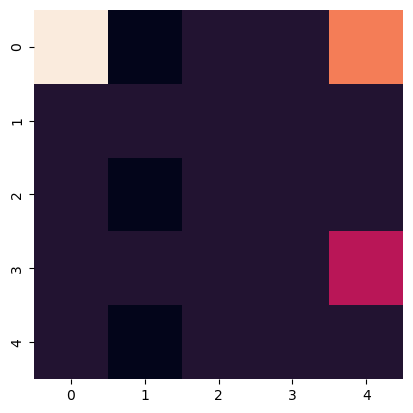

In [6]:
fig = plt.figure()

# data_list = []
# Preencher a lista: cada item da lista é uma matriz com os valores de cada iteração

def init(N):
    sns.heatmap(np.zeros((N,N)), square=True, cbar=False)

def animate(i):
    data = data_list[i]
    print(i)
    sns.heatmap(data, square=True, cbar=False)

anim = animation.FuncAnimation(fig, animate, init_func=init(N), frames=len(data_list), repeat=False)

pillowwriter = animation.PillowWriter(fps=5)

anim.save(output_file_name + ".gif", writer=pillowwriter)